In [42]:
import numpy as np
import pandas as pd
import json
import ast

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import pyrfume

from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, Descriptors, rdMolDescriptors
from mordred import Calculator, descriptors


In [43]:
def combine_lists_for_duplicates(df):
    combined_df = pd.DataFrame(columns=df.columns)  # Initialize an empty DataFrame with the same columns

    for index, group in df.groupby(df.index):
        if len(group) > 1:  # If duplicate index
            combined_lists = sum(group['Descriptors'], [])  # Combine lists
            combined_df = pd.concat([combined_df, pd.DataFrame({'Descriptors': [combined_lists]}, index=[index])])  # Concatenate to combined DataFrame
        else:
            combined_df = pd.concat([combined_df, group])  # If not a duplicate, just concatenate the row

    return combined_df


In [44]:
csv_arc = pyrfume.load_data('prediction_targets/arctander_1960.csv')
csv_arc['Descriptors'] = csv_arc['Descriptors'].apply(ast.literal_eval)
csv_arc = combine_lists_for_duplicates(csv_arc)

In [45]:
with open('compounds.json', 'r') as file:
    string_compounds = json.load(file)
    compounds = {int(k): v for k, v in string_compounds.items()}
    del string_compounds

In [46]:
def normalize_column(col):
    return (col - col.mean()) / col.std()

In [47]:
def calc_corrs(df, cols):
    all_corrs = []
    for i, col in enumerate(cols):
        print(i)
        all_corrs.append([])
        for ccol in cols:
            all_corrs[-1].extend([df[col].corr(df[ccol])])

    return np.array(all_corrs)

In [48]:
def get_cum_indices(norm_df):
    pca = PCA()
    pca.fit(norm_df)
    df_pca = pca.transform(norm_df)
    df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])

    # Calculate cumulative sum
    cumulative_sum = np.cumsum(pca.explained_variance_ratio_)

    # Find the index where cumulative sum crosses 0.9, 0.95, and 0.99
    index_90 = np.argmax(cumulative_sum >= 0.9)
    index_95 = np.argmax(cumulative_sum >= 0.95)
    index_99 = np.argmax(cumulative_sum >= 0.99)
    index_999 = np.argmax(cumulative_sum >= 0.999)

    # Get the absolute loadings for each principal component
    loadings_abs = pd.DataFrame(abs(pca.components_), columns=norm_df.columns)

    significant_columns = loadings_abs.idxmax(axis=1).drop_duplicates()

    return (index_90, index_95, index_99, index_999), significant_columns, pca.explained_variance_ratio_, loadings_abs

In [49]:
arc_exp_cols = [c.capitalize() for c in set(csv_arc['Descriptors'].explode().tolist())]
arc_exp_cols

['Aromatique',
 'Metallic',
 'Jasmin',
 'Hyacinth',
 'Sandalwood',
 'Green',
 'Tarry',
 'Fruity',
 'Orris',
 'Spicy',
 'Peppery',
 'Lilac',
 'Coco',
 'Floral',
 'Coconut',
 'Banana',
 'Honey',
 'Aldehydic',
 'Tea',
 'Green,',
 'Leafy',
 'Sour',
 'Vanillin',
 'Herbaceous',
 'Basalmic',
 'Mushroom',
 'Must',
 'Anisic',
 'Sulfuraceous',
 'Root',
 'Wood',
 'Geranium',
 'Foral',
 'Herbal',
 'Lily',
 'Peach',
 'Lillac',
 'Orange-blossom',
 'Leather',
 'Waxy',
 'Animal',
 'Apple',
 'Buttery',
 'Acid',
 'Citrus',
 'Citrusy',
 'Plum',
 'Musty',
 'Gas',
 'Ehtereal',
 'Mossy',
 'Fruit',
 'Woody',
 'Ethereal',
 'Pepper',
 'Brandy',
 'Oily',
 'Tobacco',
 'Grape',
 'Piney',
 'Vanilla',
 'Smoky',
 'Rose',
 'Aromatic',
 'Camphor',
 'Ambre',
 'Fatty',
 'Nut',
 'Pineapple',
 'Mushroomy',
 'Gassy',
 'Orange',
 'Narcissus',
 'Nutty',
 'Leathery',
 'Rosy',
 'Aldehidic',
 'Mimosa',
 'Powdery',
 'Hay',
 'Musk',
 'Caramelic',
 'Minty',
 'Rooty',
 'Winey',
 'Vanlilin',
 'Musky',
 'Camphoraceous',
 'Almondy',
 

In [50]:
smell_groups = {
    "Floral": ["Floral", "Foral", "Rose", "Lilac", "Violet", "Narcissus", "Lily", "Mimosa", "Geranium", "Rosy", "Hyacinth", "Jasmin", "Orange-blossom", "Lillac", "Orris"],
    "Fruity": ["Fruity", "Fruit", "Banana", "Peachy", "Apricot", "Apple", "Orange", "Berry", "Grape", "Pineapple", "Peach", "Pear", "Plum", "Coco", "Brandy", "Almondy", "Woney", "Citrus", "Citrusy"],
    "Herbal": ["Mint", "Hay", "Tea", "Herbal", "Herbaceous", "Minty", "Anisic"],
    "Green": ["Green", "Green,", "Mossy", "Leafy",],
    "Woody": ["Sandalwood", "Woody", "Wood", "Pine", "Piney", "Ambre", "Smoky"],
    "Sweet": ["Honey", "Caramelic", "Buttery", "Creamy", "Vanilla", "Vanillin", "Vanlilin", "Coconut", "Winey"],
    "Balsamic": ["Balsamic", "Basalmic"],
    "Earth": ["Earthy", "Musty", "Must", "Rooty", "Root", "Mushroom", "Mushroomy"],
    "Spicy": ["Pepper", "Peppery", "Spicy", "Aldehidic"],
    "Chemical": ["Acid", "Gas", "Gassy", "Aldehydic", "Metallic", "Phenolic", "Sulfuraceous", "Medicinal"],
    "Animalic": ["Animal", "Musk", "Musky", "Leathery", "Leather"],
    "Nutty": ["Nut", "Almond", "Nutty"],
    "Other": ["Aromatique", "Aromatic", "Camphoraceous", "Ethereal", "Ehtereal", "Waxy", "Camphor", "Oily", "Tarry", "Sour", "Powdery", "Fatty", "Tobacco"]
}

l = []
for e in [v for k, v in smell_groups.items()]:
    for ee in e:
        if ee in l:
            print(ee)
    l.extend(e)

inverted_smell_groups = {}
for key, values in smell_groups.items():
    for value in values:
        inverted_smell_groups[value] = key

inverted_smell_groups

{'Floral': 'Floral',
 'Foral': 'Floral',
 'Rose': 'Floral',
 'Lilac': 'Floral',
 'Violet': 'Floral',
 'Narcissus': 'Floral',
 'Lily': 'Floral',
 'Mimosa': 'Floral',
 'Geranium': 'Floral',
 'Rosy': 'Floral',
 'Hyacinth': 'Floral',
 'Jasmin': 'Floral',
 'Orange-blossom': 'Floral',
 'Lillac': 'Floral',
 'Orris': 'Floral',
 'Fruity': 'Fruity',
 'Fruit': 'Fruity',
 'Banana': 'Fruity',
 'Peachy': 'Fruity',
 'Apricot': 'Fruity',
 'Apple': 'Fruity',
 'Orange': 'Fruity',
 'Berry': 'Fruity',
 'Grape': 'Fruity',
 'Pineapple': 'Fruity',
 'Peach': 'Fruity',
 'Pear': 'Fruity',
 'Plum': 'Fruity',
 'Coco': 'Fruity',
 'Brandy': 'Fruity',
 'Almondy': 'Fruity',
 'Woney': 'Fruity',
 'Citrus': 'Fruity',
 'Citrusy': 'Fruity',
 'Mint': 'Herbal',
 'Hay': 'Herbal',
 'Tea': 'Herbal',
 'Herbal': 'Herbal',
 'Herbaceous': 'Herbal',
 'Minty': 'Herbal',
 'Anisic': 'Herbal',
 'Green': 'Green',
 'Green,': 'Green',
 'Mossy': 'Green',
 'Leafy': 'Green',
 'Sandalwood': 'Woody',
 'Woody': 'Woody',
 'Wood': 'Woody',
 'Pine

In [51]:
arc_exp = pd.DataFrame(columns=list(smell_groups.keys()), index=csv_arc.index).fillna(0)
for index, row in csv_arc.iterrows():
    for d in row['Descriptors']:
        D = d.capitalize()
        if D in inverted_smell_groups:
            arc_exp.loc[index, inverted_smell_groups[D]] = 1
print(arc_exp.mean())
arc_exp

Floral      0.386890
Fruity      0.368106
Herbal      0.258593
Green       0.254197
Woody       0.177858
Sweet       0.151878
Balsamic    0.095524
Earth       0.087530
Spicy       0.083133
Chemical    0.080336
Animalic    0.067546
Nutty       0.035971
Other       0.350120
dtype: float64


,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,Animalic,Nutty,Other
107,0,0,0,0,0,1,1,0,0,0,0,0,0
126,0,0,0,0,1,0,1,0,0,0,0,0,0
174,0,0,0,0,0,0,0,1,0,0,0,0,0
176,0,0,0,0,0,0,0,0,0,0,0,0,1
177,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143411647,0,0,1,0,0,0,0,0,1,0,0,0,0
143963103,0,0,0,0,0,0,0,0,0,0,1,0,0
144116082,1,0,0,1,1,0,0,0,0,0,0,0,0
145793235,1,1,0,0,0,0,0,0,0,0,0,0,1


In [52]:
arc_red = arc_exp.drop(columns=['Other'])
arc_red = arc_red.loc[(arc_red != 0).any(axis=1)]
print(arc_red.mean())
print(arc_red.mean().mean())
arc_red

Floral      0.404682
Fruity      0.385033
Herbal      0.270485
Green       0.265886
Woody       0.186037
Sweet       0.158863
Balsamic    0.099916
Earth       0.091555
Spicy       0.086957
Chemical    0.084030
Animalic    0.070652
Nutty       0.037625
dtype: float64
0.17847686733556298


,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,Animalic,Nutty
107,0,0,0,0,0,1,1,0,0,0,0,0
126,0,0,0,0,1,0,1,0,0,0,0,0
174,0,0,0,0,0,0,0,1,0,0,0,0
177,0,0,0,0,0,1,0,0,0,0,0,0
179,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
143411647,0,0,1,0,0,0,0,0,1,0,0,0
143963103,0,0,0,0,0,0,0,0,0,0,1,0
144116082,1,0,0,1,1,0,0,0,0,0,0,0
145793235,1,1,0,0,0,0,0,0,0,0,0,0


In [68]:
calc = Calculator(descriptors)

arc_mol = pd.DataFrame(index=arc_red.index)
arc_mol['SMILES'] = [compounds[cid]['isomeric_smiles'] for cid in arc_mol.index]

arc_des = calc.pandas(Chem.MolFromSmiles(smi) for smi in arc_mol['SMILES'])
# arc_des = arc_des.fill_missing().astype(float).dropna(axis=1)

2024it [04:19,  2.58it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2043it [04:20,  9.70it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2082it [04:24,  8.98it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2254it [04:45, 14.60it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2392it [05:05,  7.82it/s]


In [69]:
PandasTools.AddMoleculeColumnToFrame(arc_mol, smilesCol='SMILES')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,SMILES,ROMol
107,C1=CC=C(C=C1)CCC(=O)O,
126,C1=CC(=CC=C1C=O)O,
174,C(CO)O,
177,CC=O,
179,CC(C(=O)C)O,
...,...,...
143411647,CC.C=CC1=CC=C(C=C1)C=O,
143963103,CC1=C(C=C(C=C1C(C)C)C=O)C(C)C,
144116082,CCC(=O)C1(CCC(CC1)C(C)C)C,
145793235,CC(C)CCC(=CCCC(=CC=O)C)C,

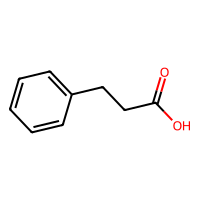
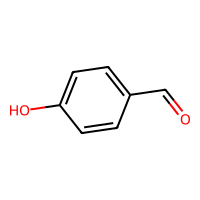
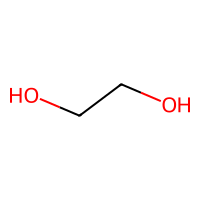
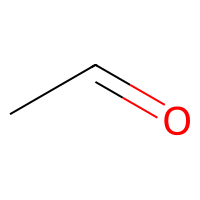
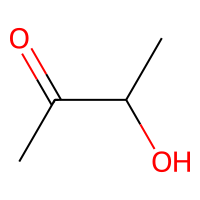
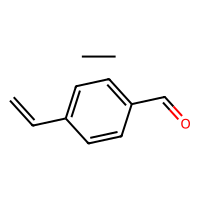
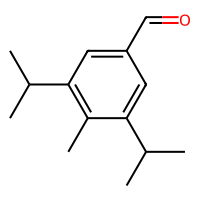
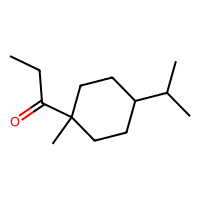
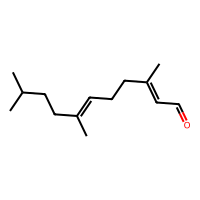
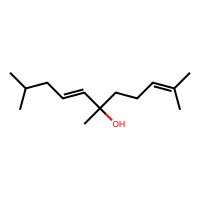

In [70]:
arc_mol

In [ ]:
# # Write each molecule to an MDL Mol file
# for i, (cid, mol) in enumerate(arc_mol['ROMol'].items()):
#     mol_file_name = f'../data/molecules/{i // 1000}/{cid}.mol'
#     # Write mol to file
#     with open(mol_file_name, 'w') as mol_file:
#         mol_file.write(Chem.MolToMolBlock(mol))

In [ ]:
# import os

# def concat_csv_files(output_file, input_files):
#     # Read each CSV file into a DataFrame and concatenate them
#     dfs = [pd.read_csv(f'../data/{file}') for file in input_files]
#     combined_df = pd.concat(dfs, ignore_index=True)

#     # Write the combined DataFrame to a new CSV file
#     combined_df.to_csv(output_file, index=False)

# # Example usage
# output_file = 'PaDEL_output.csv'
# input_files = ['PaDEL_output0.csv', 'PaDEL_output1.csv', 'PaDEL_output2.csv']

# if os.path.exists(output_file):
#     os.remove(output_file)

# concat_csv_files(output_file, input_files)


In [ ]:
arc_PaDEL = pd.read_csv('../data/PaDEL_output.csv')
arc_PaDEL

In [ ]:
arc_PaDEL['CID'] = arc_PaDEL['Name'].str.split('_').str[1]
arc_PaDEL = arc_PaDEL.drop(columns=['Name']).set_index('CID')
arc_PaDEL.index = arc_PaDEL.index.astype(int)

In [ ]:
zero_cols = arc_PaDEL.columns[arc_PaDEL.eq(0).all()]
arc_PaDEL = arc_PaDEL.drop(columns=zero_cols)
arc_PaDEL

In [ ]:
PaDEL_des_cols = arc_PaDEL.columns[:1182]
PaDEL_fin_cols = arc_PaDEL.columns[1182:]
PaDEL_des_cols

In [ ]:
# dropna removes div by zero, which happend when all rows are the same
arc_PaDEL[PaDEL_des_cols] = arc_PaDEL[PaDEL_des_cols].apply(normalize_column, axis=0)
arc_PaDEL = arc_PaDEL.dropna(axis=1)
arc_PaDEL

In [ ]:
arc_PaDEL_dataset = arc_red.join(arc_PaDEL, how='inner')

In [ ]:
arc_PaDEL_dataset = arc_PaDEL_dataset.drop(index=[62074])
arc_PaDEL_dataset.to_csv('../data/arc_PaDEL.csv')

In [ ]:
var_indices_PaDEL, significant_columns_PaDEL, explained_variance_PaDEL, loading_abs_PaDEL = get_cum_indices(arc_PaDEL)

In [ ]:
var_indices_PaDEL, significant_columns_PaDEL

In [ ]:
arc_des = arc_des.fill_missing().dropna(axis=1, how='all')
arc_missing_half = (arc_des.fill_missing().dropna(axis=1, how='all').isna().sum().sort_values() > len(arc_des) / 2)
arc_missing_half_indices = arc_missing_half[arc_missing_half].index
arc_des = arc_des.drop(columns=arc_missing_half_indices)
arc_des

In [ ]:
arc_des_median = arc_des.fillna(arc_des.median())
arc_des_zero = arc_des.fillna(0)

In [ ]:
arc_des_using = arc_des_zero
norm_arc_des = arc_des_using.apply(normalize_column, axis=0).dropna(axis=1)

In [ ]:
norm_arc_des

In [ ]:
var_indices_des, significant_columns_des, explained_variance_des, loading_abs_des = get_cum_indices(norm_arc_des)

In [ ]:
var_indices_des, significant_columns_des

In [ ]:
print(f'added len: {len(set(significant_columns_PaDEL)) + len((set(significant_columns_des)))}')
print(f'union len: {len(set(significant_columns_PaDEL).union(set(significant_columns_des)))}')

In [ ]:
arc_PaDEL = arc_PaDEL.sort_index()
arc_PaDEL

In [ ]:
norm_arc_des.index = arc_red.index
norm_arc_des

In [ ]:
arc_comb = arc_PaDEL.combine_first(norm_arc_des).dropna(axis=0)
arc_comb

In [ ]:
var_indices_comb, significant_columns_comb, explained_variance_comb, loading_abs_comb = get_cum_indices(arc_comb)

In [ ]:
var_indices_comb, significant_columns_comb

In [ ]:
diff_PaDEL = len(set(significant_columns_comb) - set(significant_columns_PaDEL))
diff_des = len(set(significant_columns_comb) - set(significant_columns_des))

num_shared = (diff_PaDEL + diff_des) - len(significant_columns_comb)
num_Padel = diff_PaDEL - num_shared
num_des = diff_des - num_shared

f'num_shared:{num_shared}, num_Padel:{num_Padel}, num_des:{num_des}'

In [ ]:
arc_comb_dataset = arc_red.join(arc_comb[significant_columns_comb], how='inner')
arc_comb_dataset

In [ ]:
arc_comb_dataset = arc_comb_dataset.drop(index=[62074])
arc_comb_dataset.to_csv('../data/arc_comb_red.csv')

In [ ]:
arc_reset = arc_red.reset_index(drop=True)

# dataset = pd.concat([arc_reset, arc_des_using[significant_columns]], axis=1)
dataset = pd.concat([arc_reset, arc_des_using], axis=1)
dataset.index = arc_red.index

# IGNORE 2 EXTREMELY LARGE ATOMS
dataset = dataset.drop(index=[62074, 16129878])
dataset.to_csv('../data/arc_median.csv')
dataset

In [ ]:
arc_red.mean()

In [65]:
arc_red

,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,Animalic,Nutty
107,0,0,0,0,0,1,1,0,0,0,0,0
126,0,0,0,0,1,0,1,0,0,0,0,0
174,0,0,0,0,0,0,0,1,0,0,0,0
177,0,0,0,0,0,1,0,0,0,0,0,0
179,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
143411647,0,0,1,0,0,0,0,0,1,0,0,0
143963103,0,0,0,0,0,0,0,0,0,0,1,0
144116082,1,0,0,1,1,0,0,0,0,0,0,0
145793235,1,1,0,0,0,0,0,0,0,0,0,0


In [66]:
print((arc_red[['Floral', 'Fruity', 'Woody']].sum(axis=1) == 0).sum())
print((arc_red[['Floral', 'Fruity', 'Woody']].sum(axis=1) == 1).sum())
print((arc_red[['Floral', 'Fruity', 'Woody']].sum(axis=1) == 2).sum())
print((arc_red[['Floral', 'Fruity', 'Woody']].sum(axis=1) == 3).sum())

584
1308
474
26


In [67]:
arc_mini = arc_red[['Floral', 'Fruity', 'Woody']]
arc_mini = arc_mini[arc_mini.sum(axis=1) < 2]
arc_mini['Odourless'] = (arc_mini.sum(axis=1) == 0).astype(int)
print(arc_mini.sum())
arc_mini

Floral       523
Fruity       544
Woody        241
Odourless    584
dtype: int64


,Floral,Fruity,Woody,Odourless
107,0,0,0,1
126,0,0,1,0
174,0,0,0,1
177,0,0,0,1
179,0,0,0,1
...,...,...,...,...
141148634,1,0,0,0
141266555,0,1,0,0
141700439,0,0,1,0
143411647,0,0,0,1


In [68]:
arc_mini_comb_dataset = arc_mini.join(arc_comb[significant_columns_comb], how='inner')
arc_mini_comb_dataset

NameError: name 'arc_comb' is not defined

In [ ]:
arc_mini_comb_dataset = arc_mini_comb_dataset.drop(index=[62074])
arc_mini_comb_dataset.to_csv('../data/arc_mini_comb_red.csv')

In [71]:
import nistchempy as nist
nist_webbook = nist.get_all_data()

In [72]:
nist_webbook

,ID,name,formula,mol_weight,inchi,inchi_key,cas_rn,mol2D,mol3D,cIR,...,cGC,cTG,cTC,cTP,cSO,cTR,cIE,cIC,cES,cDI
0,B100,iron oxide anion,FeO-,71.8450,<NA>,<NA>,<NA>,False,False,False,...,False,True,False,False,False,True,True,False,False,False
1,B1000,AsF3..Cl anion,AsClF3-,167.3700,<NA>,<NA>,<NA>,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,B1000000,AgH2-,AgH2-,109.8846,<NA>,<NA>,<NA>,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,B1000001,HAg(H2),AgH3,110.8920,<NA>,<NA>,<NA>,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,B1000002,AgNO+,AgNO+,137.8738,<NA>,<NA>,<NA>,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129000,U99777,"Methyl 3-hydroxycholest-5-en-26-oate, TMS deri...",C31 H54 O3 Si,502.8442,InChI=1S/C31H54O3Si/c1-21(10-9-11-22(2)29(32)3...,DNXGNXYNSBCWGX-QBUYVTDMSA-N,<NA>,True,False,False,...,True,False,False,False,False,False,False,False,False,False
129001,U99830,"2-Methyl-3-oxovaleric acid, O,O'-bis(trimethyl...",C12 H26 O3 Si2,274.5040,"InChI=1S/C12H26O3Si2/c1-9-11(14-16(3,4)5)10(2)...",LXAIQDVPXKOIGO-KHPPLWFESA-N,<NA>,True,False,False,...,True,False,False,False,False,False,False,False,False,False
129002,U99942,3-Hydroxy-3-(4'-hydroxy-3'-methoxyphenyl)propi...,C19 H36 O5 Si3,428.7426,InChI=1S/C19H36O5Si3/c1-21-18-13-15(11-12-16(1...,QCMUGKOFXVYNCF-UHFFFAOYSA-N,<NA>,True,False,False,...,True,False,False,False,False,False,False,False,False,False
129003,U99947,"2-Propylpentanoic acid, 2,3,4,6-tetra(trimethy...",C26 H58 O7 Si4,595.0765,InChI=1S/C26H58O7Si4/c1-15-17-20(18-16-2)25(27...,OVXMRISJDUWFKB-UHFFFAOYSA-N,<NA>,True,False,False,...,True,False,False,False,False,False,False,False,False,False


In [83]:
# Assuming you have a function to convert RDKit molecule to InChIKey
def mol_to_inchikey(mol):
    return Chem.inchi.MolToInchiKey(mol)

# Generate mass spectra data for each molecule
inchi_key = []
for mol in arc_mol['ROMol']:
    inchi_key.append(mol_to_inchikey(mol))
arc_mol['inchi_key'] = inchi_key
arc_mol['CID'] = arc_mol.index

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,SMILES,ROMol,inchi_key,CID
107,C1=CC=C(C=C1)CCC(=O)O,,XMIIGOLPHOKFCH-UHFFFAOYSA-N,107
126,C1=CC(=CC=C1C=O)O,,RGHHSNMVTDWUBI-UHFFFAOYSA-N,126
174,C(CO)O,,LYCAIKOWRPUZTN-UHFFFAOYSA-N,174
177,CC=O,,IKHGUXGNUITLKF-UHFFFAOYSA-N,177
179,CC(C(=O)C)O,,ROWKJAVDOGWPAT-UHFFFAOYSA-N,179
...,...,...,...,...
143411647,CC.C=CC1=CC=C(C=C1)C=O,,UGBGNFFDDBTUAY-UHFFFAOYSA-N,143411647
143963103,CC1=C(C=C(C=C1C(C)C)C=O)C(C)C,,TUPOLXKRHSQLST-UHFFFAOYSA-N,143963103
144116082,CCC(=O)C1(CCC(CC1)C(C)C)C,,YEUYMNVZJAIVJX-UHFFFAOYSA-N,144116082
145793235,CC(C)CCC(=CCCC(=CC=O)C)C,,XIPPRSCORVGCQK-UHFFFAOYSA-N,145793235

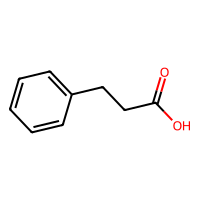
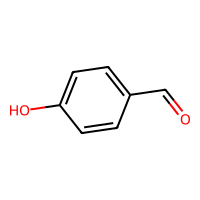
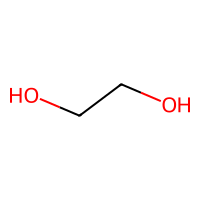
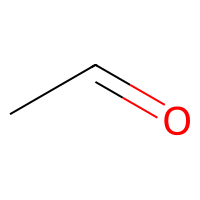
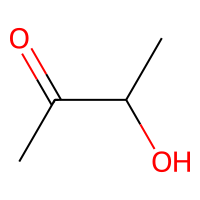
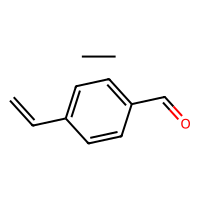
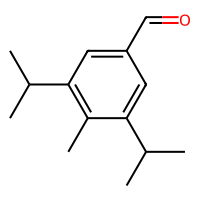
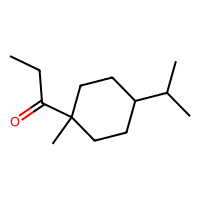
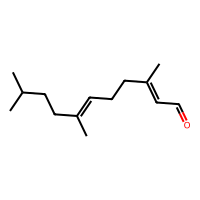
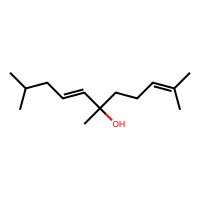

In [84]:
arc_mol

In [129]:
merged_df = arc_mol[['CID', 'SMILES', 'inchi_key']].merge(nist_webbook[['ID', 'inchi_key']], on='inchi_key', how='inner')
merged_df

,CID,SMILES,inchi_key,ID
0,107,C1=CC=C(C=C1)CCC(=O)O,XMIIGOLPHOKFCH-UHFFFAOYSA-N,C501520
1,126,C1=CC(=CC=C1C=O)O,RGHHSNMVTDWUBI-UHFFFAOYSA-N,C123080
2,174,C(CO)O,LYCAIKOWRPUZTN-UHFFFAOYSA-N,B6009514
3,174,C(CO)O,LYCAIKOWRPUZTN-UHFFFAOYSA-N,C107211
4,177,CC=O,IKHGUXGNUITLKF-UHFFFAOYSA-N,C75070
...,...,...,...,...
1442,53959463,CCCCCCCCCCC(=O)OCCC(C)C,JJXRRRGUDICKPR-UHFFFAOYSA-N,R409948
1443,54052443,CCCCCCCCCCCCC(=O)OCC(C)C,DBSNEMMWHLXCPX-UHFFFAOYSA-N,U405160
1444,54682930,C1=CC=C2C(=C1)C(=CC(=O)O2)O,VXIXUWQIVKSKSA-UHFFFAOYSA-N,C1076386
1445,67351117,CCCCCOC(=O)C(C)C1=CC=CC=C1,HDVFGKKFXKECPD-UHFFFAOYSA-N,U415061


In [132]:
merged_df['CID'] = merged_df['CID'].drop_duplicates()
merged_df = merged_df.dropna(subset=['CID'])
merged_df['CID'] = merged_df['CID'].astype(int)
merged_df

,CID,SMILES,inchi_key,ID
0,107,C1=CC=C(C=C1)CCC(=O)O,XMIIGOLPHOKFCH-UHFFFAOYSA-N,C501520
1,126,C1=CC(=CC=C1C=O)O,RGHHSNMVTDWUBI-UHFFFAOYSA-N,C123080
2,174,C(CO)O,LYCAIKOWRPUZTN-UHFFFAOYSA-N,B6009514
4,177,CC=O,IKHGUXGNUITLKF-UHFFFAOYSA-N,C75070
5,179,CC(C(=O)C)O,ROWKJAVDOGWPAT-UHFFFAOYSA-N,C513860
...,...,...,...,...
1442,53959463,CCCCCCCCCCC(=O)OCCC(C)C,JJXRRRGUDICKPR-UHFFFAOYSA-N,R409948
1443,54052443,CCCCCCCCCCCCC(=O)OCC(C)C,DBSNEMMWHLXCPX-UHFFFAOYSA-N,U405160
1444,54682930,C1=CC=C2C(=C1)C(=CC(=O)O2)O,VXIXUWQIVKSKSA-UHFFFAOYSA-N,C1076386
1445,67351117,CCCCCOC(=O)C(C)C1=CC=CC=C1,HDVFGKKFXKECPD-UHFFFAOYSA-N,U415061


In [2]:
merged_df = pd.read_csv('../data/temp_df.csv')

In [152]:
# for i, id in enumerate(merged_df['ID']):
#     print(i)
#     c = nist.Compound(id)
#     c.get_ms_spectra()
#     for ms in c.MS:
#         ms.save(path_dir='../data/ms_specs/')

# f'{c.MS[0].compound.ID}_{c.MS[0].spec_type}_{c.MS[0].spec_idx}.jdx'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [38]:
# x_range = [0,343]
ms_specs = pd.DataFrame(columns=[i for i in range(344)], index=merged_df['CID']).fillna(0)
ms_specs

,0,1,2,3,4,5,6,7,8,9,...,334,335,336,337,338,339,340,341,342,343
CID,,,,,,,,,,,,,,,,,,,,,
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53959463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54052443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54682930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
for (cid, id) in zip(merged_df['CID'], merged_df['ID']):
    # print(cid, id)
    file_name = f'../data/ms_specs/{id}_MS_0.jdx'
    try:
        with open(file_name, 'r') as file:
            content = file.read()
            peaks = [(int(x), int(y)) for x,y in [s.split(',') for s in ' '.join(content.split('\n')[25:-2]).split(' ')]]
            for (x, y) in peaks:
                ms_specs.loc[cid,x] = y
    except:
        continue

ms_specs

,0,1,2,3,4,5,6,7,8,9,...,334,335,336,337,338,339,340,341,342,343
CID,,,,,,,,,,,,,,,,,,,,,
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,0,0,0,0,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53959463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54052443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54682930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
ms_specs = ms_specs.loc[(ms_specs != 0).any(axis=1)]
ms_specs = ms_specs / 9999
ms_specs

,0,1,2,3,4,5,6,7,8,9,...,334,335,336,337,338,339,340,341,342,343
CID,,,,,,,,,,,,,,,,,,,,,
107,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0.0,0.0,0.0,0.0,0.0,0.0021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372353,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5372813,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5373729,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
ms_specs.to_csv('../data/ms_specs.csv')

In [58]:
arc_red

,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,Animalic,Nutty
107,0,0,0,0,0,1,1,0,0,0,0,0
126,0,0,0,0,1,0,1,0,0,0,0,0
174,0,0,0,0,0,0,0,1,0,0,0,0
177,0,0,0,0,0,1,0,0,0,0,0,0
179,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
143411647,0,0,1,0,0,0,0,0,1,0,0,0
143963103,0,0,0,0,0,0,0,0,0,0,1,0
144116082,1,0,0,1,1,0,0,0,0,0,0,0
145793235,1,1,0,0,0,0,0,0,0,0,0,0


In [63]:
arc_ms_spec = pd.merge(arc_red, ms_specs, left_index=True, right_index=True)
arc_ms_spec.to_csv('../data/arc_ms_spec.csv')
arc_ms_spec

,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,...,334,335,336,337,338,339,340,341,342,343
107,0,0,0,0,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0,0,0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372353,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5372813,0,0,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5373729,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6040503,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
arc_mini

,Floral,Fruity,Woody,Odourless
107,0,0,0,1
126,0,0,1,0
174,0,0,0,1
177,0,0,0,1
179,0,0,0,1
...,...,...,...,...
141148634,1,0,0,0
141266555,0,1,0,0
141700439,0,0,1,0
143411647,0,0,0,1


In [70]:
arc_mini_ms_spec = pd.merge(arc_mini, ms_specs, left_index=True, right_index=True)
arc_mini_ms_spec.to_csv('../data/arc_mini_ms_spec.csv')
arc_mini_ms_spec

,Floral,Fruity,Woody,Odourless,0,1,2,3,4,5,...,334,335,336,337,338,339,340,341,342,343
107,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5371102,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5372353,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5372813,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5373729,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
ms_spec_vars = ms_specs.var().sort_values(ascending=False)
total_val = ms_spec_vars.sum()
rel_var_cumsum = ms_specs.var().sort_values(ascending=False).cumsum() / total_val

for var in [0.9, 0.95, 0.99, 0.999]:
    print(f'var {var}: {len(rel_var_cumsum[rel_var_cumsum < var])}')


var 0.9: 86
var 0.95: 110
var 0.99: 156
var 0.999: 194


In [124]:
len(ms_specs.columns) - (ms_specs.sum() == 0).sum()

306

In [98]:
var_ordered_ms_specs = ms_specs[ms_specs.var().sort_values(ascending=False).index]
arc_red_ms_specs_ordered = pd.merge(arc_red, var_ordered_ms_specs, left_index=True, right_index=True)
arc_red_ms_specs_ordered.to_csv('../data/arc_ms_spec_ordered.csv')
arc_red_ms_specs_ordered

,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,...,273,322,1,314,317,318,319,320,300,0
107,0,0,0,0,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0,0,0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372353,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5372813,0,0,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5373729,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6040503,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
